# Notebook 02 - Reverse-mode Autodiff & Backpropogation

### Recapping previous notebooks
__notebook 0__

1) The gradient is how changes in an input variable affects the output.

2) We can break down complex functions into smaller parts and "chain" them together.

__notebook 1__

1) We can convert a complex function into a composite function, made up of a chain of simple operations

2) We can model a composite function as a simple feed forward neural net with a graph structure, and calculate the result using a forward pass.

__So we've essentially built an unnecessary complicated version of a simple calculator__ - but we did this for a reason.

A calculator is good for taking inputs and spitting out an output. A neural network is good at taking input and output pairs, and iteratively tweaking its weights so that when it takes an input, it spits out the output that we want.

In this notebook, we'll bridge the gap and turn our calculator into a neural network in a few steps:

1) Understanding the chain rule

2) Defining the derivatives of our base operations

3) Implementing reverse-mode automatic differentiation

4) Updating weights through backpropogation

# The Chain Rule

__The chain rule is a method of calculating the gradients of a composite function.__

This rule is particularly integral to neural networks as it takes advantage of the property that neural networks, which are very complicated functions, can be broken down into a chain of primitive operations such as addition and multiplication.

This is the chain rule:

$$ \frac{dL}{dx} = \frac{dL}{dy} \cdot \frac{dy}{dx}$$

$L, y, x$ are variables, and I chose those letters to represent different parts of the neural network
- $L$ is the loss value
- $y$ is the output of a node
- $x$ is an input of a node

If we want to train a network, we need to adjust its weights to minimize the loss ("error") of a model. We want to adjust the value of each variable $x$ in a way that will minimize $L$.

How each variable affects the loss function is notated as:

$$ \frac{dL}{dx} $$

However, there might be many nested functions between our variable $x$ and the final output $L$. This might seem like a lot of added complexity, but the chain rule allows us to take advantage of this property.

__Chaining derivatives__

Let's say input $x$ is used to calculate output $y$, which is used to calculate loss $L$.

$$ x \Rightarrow y \Rightarrow L $$

To calculate the derivative of $L$ with respect to $x$, we can calculate the derivative of $L$ with respect to $y$, multiplied by the derivative of $y$ with respect to $x$.

$$ \frac{dL}{dx} = \frac{dL}{dy} \cdot \frac{dy}{dx}$$

Now let's say $w$ is used to calculate $x$, which is used to calculate $y$, which is used to calculate $z$, which is used to calculate $L$.

$$ w \Rightarrow x \Rightarrow y \Rightarrow z \Rightarrow L $$

The chain rule lets us find how $w$ affects $L$ by calculating:

$$ \frac{dL}{dw} = \frac{dL}{dz} \cdot \frac{dz}{dy} \cdot \frac{dy}{dx} \cdot \frac{dx}{dw}$$

__See how for longer sequences, we just create a longer chain of derivative multiplications?__ and since we are using a chain of primitive operations, each of these derivatives is almost trivial. Let's take an example:

$$ L = (((((a ^ 2) * 6) - 4) / 3) + 5 $$

can be broken down as
$$
\begin{equation}
\begin{aligned}
&L = e + 5\\
&e = d / 3\\
&d = c - 4\\
&c = b * 6\\
&b = a ^ 2\\
\end{aligned}
\end{equation}
$$

chaining the derivatives:

$$
\begin{equation}
\begin{aligned}
\frac{dL}{da} &= \frac{dL}{de} \cdot \frac{de}{dd} \cdot \frac{dd}{dc} \cdot \frac{dc}{db} \cdot \frac{db}{da} \\
&= 1 \cdot \frac{1}{3} \cdot  1 \cdot 6 \cdot 2a\\
&= 4a
\end{aligned}
\end{equation}
$$

double checking our result:

In [12]:
def f(a):
    return (((((a**2) * 6) - 4) / 3) + 5)

In [21]:
eps = 1e-8
a = 1
rise = f(a+eps) - f(a)
run = (a+eps)-a
gradient = rise/run
print(gradient)

4.0


# Reverse-mode Automatic Differentiation

Hopefully my explanation of the chain rule makes sense as we move into reverse-mode autodiff. This term might sound complicated, but its basically the chain rule, where we start from the Loss value and recursively apply the chain rule until we find the gradient of every weight and bias in the network. Let me try to illustrate this idea in a simplified way.

__Let's say our forward pass is like this:__

$$ x \Rightarrow y \Rightarrow L $$

where $x$ is used to calculate $y$, is used to calculate loss $L$.

__In the backward pass:__
1) We start from loss $L$, and we see that it used $y$

  - Find the gradient of $y$ using $\frac{dL}{dy}$

2) We see that $y$ used variable $x$

  - Find the gradient of $\frac{dL}{dx}$ by calculating $\frac{dL}{dy} \frac{dy}{dx}$
  - Since we already calculated $\frac{dL}{dy}$ in the first step, really we just need to calculate $\frac{dy}{dx}$ and multiply the two together


# Implementation

Lets add reverse-mode autodiff to KaiTorch, recall our `Scalar` class:

In [23]:
# kaitorch/core.py

import math

class Scalar:

    def __init__(self, data, _in=(), _op=''):
        self.data = data
        self.grad = 0.0 # hi :)

        self._backward = lambda: None  # hi :)
        self._prev = set(_in)
        self._op = _op
        
    def __repr__(self):
        return f'Value(data={self.data})'

Recall our 5 base operations:
- Addition
- Multiplication
- Exponentiation
- Natural Exponentiation
- Natural Log

Let's define the derivative of each one by adding a `_backward()` function.

In [24]:
# kaitorch/core.py

# Addition
def __add__(a, b):

    a = a if isinstance(a, Scalar) else Scalar(a)
    b = b if isinstance(b, Scalar) else Scalar(b)

    # Calculation: y = a + b
    def _forward():
        _a = a.data
        _b = b.data
        _y = _a + _b
        return Scalar(_y, _in=(a, b), _op='+')
    y = _forward()

    # Derivative: dy/da = 1
    # Chain Rule: dL/da = dL/dy * dy/da
    #                   = dL/dy
    def _backward():
        a.grad += y.grad
        b.grad += y.grad
    y._backward = _backward

    return y

Scalar.__add__ = __add__

In [25]:
# kaitorch/core.py

# Multiplication
def __mul__(a, b):

    a = a if isinstance(a, Scalar) else Scalar(a)
    b = b if isinstance(b, Scalar) else Scalar(b)

    # Calculation: y = a * b
    def _forward():
        _a = a.data
        _b = b.data
        _y = _a * _b
        return Scalar(_y, _in=(a, b), _op='*')
    y = _forward()

    # Derivative: dy/da = b
    # Chain Rule: dL/da = dL/dy * dy/da
    #                   = dL/dy * b
    def _backward():
        a.grad += y.grad * b.data
        b.grad += y.grad * a.data
    y._backward = _backward

    return y

Scalar.__mul__ = __mul__

In [26]:
# kaitorch/core.py

# Exponentiation
def __pow__(a, b):

    assert isinstance(b, (int, float)), "Exponent is not int/float"

    # Calculation: y = a ** b
    def _forward():
        _a = a.data
        _y = (_a + 1e-7) ** b  # don't divide by 0 :)
        return Scalar(_y, _in=(a,), _op=f'**{b}')
    y = _forward()

    # Derivative: dy/da = b * (a ** (b-1))
    # Chain Rule: dL/da = dL/dy * dy/da
    #                   = dL/dy * b * (a ** (b-1))
    def _backward():
        a.grad += y.grad * (b * a.data ** (b - 1))
    y._backward = _backward

    return y

Scalar.__pow__ = __pow__

In [27]:
# kaitorch/core.py

# Natural Exponentiation
def exp(a):

    # Calculation: y = e ** a
    def _forward():
        _a = a.data
        _y = math.exp(_a)
        return Scalar(_y, _in=(a, ), _op='exp')
    y = _forward()

    # Derivative: dy/da = y
    # Chain Rule: dL/da = dL/dy * dy/da
    #                   = dL/dy * y
    def _backward():
        a.grad += y.grad * y.data
    y._backward = _backward

    return y

Scalar.exp = exp

In [28]:
# kaitorch/core.py

# Natural Log
def log(a):

    # Calculation: y = ln(a)
    def _forward():
        _a = a.data
        _y = math.log(_a + 1e-8)

        return Scalar(_y, _in=(a, ), _op='ln')
    y = _forward()

    # Derivative: dy/da = 1/a * a'
    # Chain Rule: dL/da = dL/dy * dy/da * a'
    #                   = dL/dy * 1/a * a'
    def _backward():
        a.grad += y.grad * ((a.data + 1e-8).__pow__(-1))
    y._backward = _backward

    return y

Scalar.log = log

You might have noticed that the `_forward()` is automatically called, but `_backward` isn't. This is because we don't want to/can't calculate the derivatives during the forward pass. We just tell the `Scalar` to remember how to calculate the derivative, and then call it during the backward pass.

__What about subtraction, division, and negatives?__

Recall that the calculation of these operations can be achieved by chaining the `_foward()` calculations of the base operators.

Similarly, the derivative of these operations can be achieved by chaining the `_backward()` calculations of the base operators.

And just as we can calculate the value of every node during the forward pass by starting from our inputs and propogating calculation results forward, we can calculate the derivative of every node during the backward pass by starting from our loss value and propogating the gradients backward!

Copying over all the other class methods from last notebook:

In [31]:
# kaitorch/core.py

def __radd__(a, b):

    # b + a = a + b
    return a.__add__(b)

Scalar.__radd__ = __radd__

In [32]:
# kaitorch/core.py

def __rmul__(a, b):

    # b * a = a * b
    return a.__mul__(b)

Scalar.__rmul__ = __rmul__

In [33]:
# kaitorch/core.py

def __neg__(a):

    # -a = a * -1
    return a.__mul__(-1)

Scalar.__neg__ = __neg__

In [34]:
# kaitorch/core.py

def __sub__(a, b):

    # a - b = a + (b * -1)
    return a.__add__(b.__neg__())

def __rsub__(a, b):

    # b - a = (a * -1) + b
    return (a.__neg__()).__add__(b)

Scalar.__sub__ = __sub__
Scalar.__rsub__ = __rsub__

In [35]:
# kaitorch/core.py

def __truediv__(a, b):

    # a / b = a * (b ** -1)
    return a.__mul__((b + 1e-8).__pow__(-1)) # Avoid Division by 0

def __rtruediv__(a, b):

    # b / a = b * (a ** -1)
    return Scalar(b).__mul__((a + 1e-8).__pow__(-1)) # Avoid Division by 0

Scalar.__truediv__ = __truediv__
Scalar.__rtruediv__ = __rtruediv__

# Topological Sort

The last piece to finishing our implementation of reverse-mode autodiff is knowing in what order to calculate the gradients. We need to make sure that if 

$$ x \Rightarrow y \Rightarrow L $$

That we calculate the derivative of $y$ before we calculate the derivative of $x$, since when using the chain rule, $dx$ depends on $dy$.

The solution to this is a topological sort, where in a graph consisting of edges from `node X` to `node Y`, `X` always comes before `Y` in the ordering. With the above example, a topological sort would (trivially) return `[x, y, L]`.

Since we're doing a backward pass and we want to start from L, we simply reverse the topological sort to get the order in which we should calculate the derivatives, such that for each `node X` that is used to calculate `node Y`, `dY` is calculated before `dX`.

In [36]:
# kaitorch/core.py

def backward(self):

    topo = []
    visited = set()

    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

Scalar.backward = backward

__That's it! 🥳 -__ we have all the ingredients we need to calculate the gradient of every node in the network now

In [1]:
from kaitorch.graph import plot_model

In [41]:
x1 = Scalar(2.0)
w1 = Scalar(-3.0)

x2 = Scalar(0.0)
w2 = Scalar(1.0)

b = Scalar(13.5)

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2+b; n.label = 'n'

n.backward()

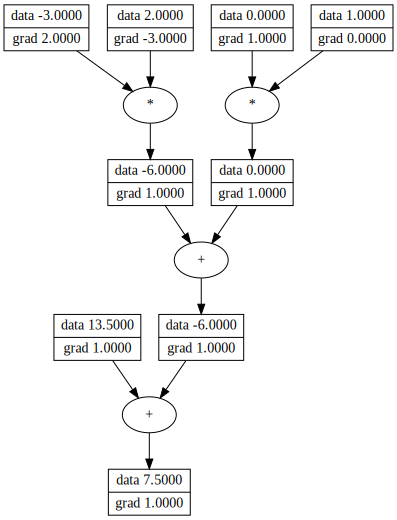

In [42]:
plot_model(n)

# Backpropogation

Backpropogation is everything we've done so far - calculating the gradients of every parameter/weight - with the added step of updating the weights of our network. There are many ways to do this which we'll cover in the following notebooks.

But before we do this, we'll want to to first implement a functional neural network with Dense layers, and cover loss functions and optimization.

keep reading $\Rightarrow$